In [20]:
import math
import numpy as np
from IPython.display import clear_output
import pdb
import time

import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from torchdiffeq import odeint_adjoint as odeint
from torch.distributions import MultivariateNormal
use_cuda = torch.cuda.is_available()
from geomloss import SamplesLoss

In [21]:
# fourier features mapping
class InputMapping(nn.Module):
    def __init__(self, d_in, d_out, sigma=10):
        super().__init__()
        self.B = nn.Parameter(torch.randn(d_out // 2, d_in) * sigma,
                              requires_grad=False)

    def forward(self, x):
        x = (2*np.pi*x) @ self.B.T
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

In [22]:
class ODEfunc(nn.Module):
    """
    Calculates time derivatives.

    torchdiffeq requires this to be a torch.nn.Module.
    """

    def __init__(self, hidden_dims=(64,64,64)):
        super(ODEfunc, self).__init__()
        # Define network layers.
        I_DIM=10
        Z_DIM=2
        dim_list = [I_DIM] + list(hidden_dims) + [Z_DIM]
        layers = []
        layers.append(utils.InputMapping(3, I_DIM));
        for i in range(len(dim_list)-1):
            layers.append(nn.Linear(dim_list[i]+1, dim_list[i+1]))
        self.layers = nn.ModuleList(layers)
        


    def get_z_dot(self, t, z):
        pdb.set_trace()
        """z_dot is parameterized by a NN: z_dot = NN(t, z(t))"""
        z_dot = utils.forward(z);
        for l, layer in enumerate(self.layers):
            # Concatenate t at each layer.
            tz_cat = torch.cat((t.expand(z.shape[0],1), z_dot), dim=1)
            z_dot = layer(tz_cat) #add time t into first spot
            # pdb.set_trace()
            if l < len(self.layers) - 1:
                #pdb.set_trace()
                z_dot = F.softplus(z_dot)
        return z_dot

    # d z_dot d z. assuming zdot was computed from z. otherwise output is just 0.
    def getJacobians(self, t, z):
        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):            
            z.requires_grad_(True)
            t.requires_grad_(True)
            z_dot = self.get_z_dot(t, z)
            
            # compute jacobian of velocity field. [N,2,2]
            # inputs z_dot.sum() because each z_dot only depends on one z. no cross derivatives. this batches the grad.
            divergence = 0.0
            dim = z.shape[1];
            jacobians = torch.zeros([batchsize,dim,dim], dtype=z.dtype, device=z.device);
            for i in range(z.shape[1]):
                 jacobians[:,i,:] = torch.autograd.grad( z_dot[:, i].sum(), z, create_graph=True)[0]
        return z_dot, jacobians
    
    def forward(self, t, state):
        """
        Calculate the time derivative of z and divergence.

        Parameters
        ----------
        t : torch.Tensor
            time
        state : torch.Tensor
            Contains z

        Returns
        -------
        z_dot : torch.Tensor
            Time derivative of z.
        negative_divergence : torch.Tensor
            Time derivative of the log determinant of the Jacobian.
        """
        z = state
        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            t.requires_grad_(True)

            # Calculate the time derivative of z.
            # This is f(z(t), t; \theta) in Eq. 4.
            z_dot = self.get_z_dot(t, z)

        return z_dot

class FfjordModel(torch.nn.Module):
    """Continuous noramlizing flow model."""

    def __init__(self):
        super(FfjordModel, self).__init__()
        self.time_deriv_func = ODEfunc()

    def save_state(self, fn='state.tar'):
        """Save model state."""
        torch.save(self.state_dict(), fn)

    def load_state(self, fn='state.tar'):
        """Load model state."""
        self.load_state_dict(torch.load(fn))


    def forward(self, z, integration_times=None, reverse=False):
        """
        Implementation of Eq. 4.
        We want to integrate both f and the trace term. During training, we
        integrate from t_1 (data distribution) to t_0 (base distibution).
        Parameters
        ----------
        z : torch.Tensor
            Samples.
        integration_times : torch.Tensor
            Which times to evaluate at.
        reverse : bool, optional
            Whether to reverse the integration times.
        Returns
        -------
        z : torch.Tensor
            Updated samples.
        """
        if integration_times is None:
            integration_times = torch.tensor([0.0, 1.0]).to(z)
        if reverse:
            integration_times = _flip(integration_times, 0)
        #print('integration_times',integration_times)
        # Integrate. This is the call to torchdiffeq.
        
        state = odeint(
            self.time_deriv_func, # Calculates time derivatives.
            z, # Values to update.
            integration_times, # When to evaluate.
            method='dopri5', # Runge-Kutta
            atol=1e-5, # Error tolerance
            rtol=2e-5, # Error tolerance
        )
        
        z = state
        return z
    
def _flip(x, dim):
    indices = [slice(None)] * x.dim()
    indices[dim] = torch.arange(x.size(dim) - 1, -1, -1, dtype=torch.long,             device=x.device)
    return x[tuple(indices)]



In [23]:


def make_image(n=10000):
    """Make an X shape."""
    points = np.zeros((n,2))
    points[:n//2,0] = np.linspace(-1,1,n//2)
    points[:n//2,1] = np.linspace(1,-1,n//2)
    points[n//2:,0] = np.linspace(1,-1,n//2)
    points[n//2:,1] = np.linspace(1,-1,n//2)
    np.random.seed(42)
    noise = np.clip(np.random.normal(scale=0.1, size=points.shape),-0.2,0.2)
    np.random.seed(None)
    points += noise
    img, _ = np.histogramdd(points, bins=40, range=[[-1.5,1.5],[-1.5,1.5]])
    return img


class ImageDataset():
    """Sample from a distribution defined by an image."""

    def __init__(self, img, MAX_VAL=4.0):
        h, w = img.shape
        xx = np.linspace(-MAX_VAL, MAX_VAL, w)
        yy = np.linspace(-MAX_VAL, MAX_VAL, h)
        xx, yy = np.meshgrid(xx, yy)
        xx = xx.reshape(-1, 1)
        yy = yy.reshape(-1, 1)
        self.means = np.concatenate([xx, yy], 1)
        self.probs = img.reshape(-1) / img.sum()
        self.noise_std = np.array([MAX_VAL/w, MAX_VAL/h])

    def sample(self, batch_size=512):
        inds = np.random.choice(int(self.probs.shape[0]), int(batch_size), p=self.probs)
        m = self.means[inds]
        samples = np.random.randn(*m.shape) * self.noise_std + m
        return torch.from_numpy(samples).type(torch.FloatTensor)
    
def import_img(file):
    """
    file : str
        filename for an rgba image
    Returns
    gimg : 2D array
        greyscale image
    """
    img = plt.imread(file)
    rgb_weights = [0.2989, 0.5870, 0.1140]
    gimg = np.dot(img[...,:3], rgb_weights)
    return gimg



In [24]:
colors = ['red','orange','magenta','cyan']


import os
def save_trajectory(model,z_target, my_loss, savedir='imgs', nsteps=20, memory=0.01, n=1000):
    """
    Plot the dynamics of the learned ODE.
    Saves images to `savedir`.
    Parameters
    ----------
    model : FfjordModel
        Model defining the dynamics.
    z_target : torch.Tensor 
        Tensor of shape (T,n,d) where T is the number of timesteps
    myloss : str
        Name of loss used to train the model
    savedir : str, optional
        Where to save output.
    ntimes : int, optional
        Number of timesteps to visualize.
    memory : float
        Controls how finely the density grid is sampled.
    n : int, optional
        Number of samples to visualize.
    """
    
    final_dir = savedir+'/'+my_loss
    if not os.path.exists(final_dir):
        os.makedirs(final_dir)
    
    T = z_target.shape[0]
    x_traj = model(z_target[0,:,:], integration_times= torch.linspace(0,T-1,nsteps).to(device)).cpu().detach()
    x_traj = x_traj.detach().numpy()

    for i in range(nsteps):
        plt.scatter(x_traj[i,:,0], x_traj[i,:,1], s=10, alpha=.5, linewidths=0, c='blue', edgecolors='black')
        for t in range(T):
            plt.scatter(z_target.cpu().detach().numpy()[t,:,0], z_target.cpu().detach().numpy()[t,:,1], s=10, alpha=.5, linewidths=0, c=colors[t], edgecolors='black')
        plt.axis('equal')
        plt.savefig(os.path.join(final_dir, f"viz-{i:05d}.jpg"))
        plt.clf()
        
#         plt.scatter(x_traj[i,:,0], x_traj[i,:,1], s=2.3, alpha=1, linewidths=0.1, c='blue')
#         plt.scatter(dat.detach().numpy()[:,0],dat.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
#         plt.scatter(dat2.detach().numpy()[:,0],dat2.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
#         plt.scatter(dat3.detach().numpy()[:,0],dat3.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
#         plt.savefig(os.path.join(final_dir, f"viz-{i:05d}.jpg"))
#         plt.clf()



def trajectory_to_video(my_loss,savedir='imgs', mp4_fn='transform.mp4'):
    """Save the images written by `save_trajectory` as an mp4."""
    import subprocess
    final_dir = savedir+'/'+my_loss
    img_fns = os.path.join(final_dir, 'viz-%05d.jpg')
    video_fn = os.path.join(final_dir, mp4_fn)
    bashCommand = 'ffmpeg -y -i {} {}'.format(img_fns, video_fn)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()



In [25]:


def learn_trajectory(z_target, my_loss, n_batch = 1500):
    
    """
        Learns a trajectory between multiple timesteps contained in z_target
        ----------
        z_target : torch.Tensor 
            Tensor of shape (T,n,d) where T is the number of timesteps
        my_loss : str
            Data fidelity loss, either 'sinkhorn_large_reg', 'sinkhorn_small_reg' or 'energy_distance'
        Returns
        -------
        model : 
            NN representing the vector field
        
        """

    if my_loss == 'sinkhorn_large_reg':
        my_loss_f =SamplesLoss("sinkhorn", p=2, blur=0.01)
    elif my_loss == 'sinkhorn_small_reg':
        my_loss_f = SamplesLoss("sinkhorn", p=2, blur=1)
    else:
        my_loss_f = SamplesLoss("energy") # Energy Distance


    model = FfjordModel()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)

    # get spacetime bounding box and spacetime sample grid
    t_N = 30; x_N = 10; bbscale = 1.1;
    T = z_target.shape[0]; t_sample = torch.linspace(1, T, t_N);
    LL = z_target.min(0)[0].min(0)[0]; TR = z_target.max(0)[0].max(0)[0]; C = (LL+TR)/2; # lower left, top right, center
    eLL = (LL-C)*1.1+C; eTR = (TR-C)*1.1+C; # extended bounding box.
    xspace = torch.linspace(eLL[0],eTR[0],x_N); yspace = torch.linspace(eLL[1],eTR[1],x_N);
    xgrid,ygrid=torch.meshgrid(xspace,yspace);
    z_sample = torch.transpose(torch.reshape(torch.stack([xgrid,ygrid]),(2,-1)),0,1);
    
    losses = []
    start = time.time()
    print('training with %s'%my_loss)
    for batch in range(n_batch):
        if (batch % 10 == 1):
            start = time.time()

        optimizer.zero_grad()
        
        # integrate ODE forward in time
        z_t = model(z_target[0,:,:], integration_times = torch.linspace(0,T-1,T).to(device))
        
        # this is the part where the loss is computed
        fitloss = torch.tensor(0.).to(device)
        for t in range(1,T):
            fitloss += my_loss_f(z_target[t,:,:], z_t[t,:,:])
    
        # add energies depending on velocity field gradient
        div2loss = torch.zeros([t_N,x_N*x_N]).to(device);
        curl2loss = torch.zeros([t_N,x_N*x_N]).to(device);
        rigid2loss = torch.zeros([t_N,x_N*x_N]).to(device);
        for ti in range(t_N):
            t = t_sample[ti]
            z_dots, zt_jacs = model.time_deriv_func.getJacobians(t, z_sample)
            
            # divergence squared
            div2loss[ti,:] += (zt_jacs[:,0,0]+zt_jacs[:,1,1])**2
            # square norm of curl
            curl2loss[ti,:] += (zt_jacs[:,0,1]-zt_jacs[:,1,0])**2
            # rigid motion: x(t) -> e^[wt] x0 + kt. v = x_dot = [w]x0+k; dvdx = [w]. ==> skew symmetric velocity gradient is rigid.
            rigid2loss[ti,:] += ((zt_jacs[:,0,1]+zt_jacs[:,1,0])**2)/2 + (zt_jacs[:,0,0])**2 + (zt_jacs[:,1,1])**2 
        
        # combine energies
        loss = fitloss + 0*div2loss.sum() + 0*curl2loss.sum() + 0*rigid2loss.sum()
        
        losses.append(loss.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
        if (batch % 10 == 0):
            print('batch',batch,'loss',loss)
            
            plt.scatter(z_target.cpu().detach().numpy()[0,:,0], z_target.cpu().detach().numpy()[0,:,1], s=10, alpha=.5, linewidths=0, c='green', edgecolors='black')
            for t in range(1,T):
                plt.scatter(z_t.cpu().detach().numpy()[t,:,0], z_t.cpu().detach().numpy()[t,:,1], s=10, alpha=.5, linewidths=0, c='blue', edgecolors='black')
                plt.scatter(z_target.cpu().detach().numpy()[t,:,0], z_target.cpu().detach().numpy()[t,:,1], s=10, alpha=.5, linewidths=0, c=colors[t], edgecolors='black')
            plt.axis('equal')
            plt.show()
            print('time elapsed',time.time()-start)

    return model



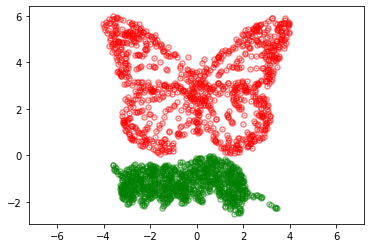

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
caterpillar = 1-import_img('caterpillar.png')
butterfly = 255-import_img('butterfly.jpg')

dset1 = ImageDataset(img=caterpillar); dset2 = ImageDataset(img=butterfly)
n = 1000; dat1 = dset1.sample(n); dat2 = dset2.sample(n)
dat1*=-1; dat2*=-1; dat1[:,1]-=1; dat2[:,1]+=2;

plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=2.3, alpha=0.5, linewidths=5,c='green')
plt.scatter(dat2.detach().numpy()[:,0],dat2.detach().numpy()[:,1],s=2.3, alpha=0.5, linewidths=5,c='red')
plt.axis('equal')
plt.show() 

In [ ]:
dat_tuple = (dat1,dat2)
z_target = torch.stack(dat_tuple).to(device)
for my_loss in ['sinkhorn_small_reg','sinkhorn_large_reg']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=3000)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)

training with sinkhorn_small_reg
> /tmp/ipykernel_170232/639840251.py(23)get_z_dot()
     21         pdb.set_trace()
     22         """z_dot is parameterized by a NN: z_dot = NN(t, z(t))"""
---> 23         z_dot = utils.forward(z);
     24         for l, layer in enumerate(self.layers):
     25             # Concatenate t at each layer.



ipdb>  utils


*** NameError: name 'utils' is not defined


ipdb>  Utils


*** NameError: name 'Utils' is not defined


ipdb>  InputMapping


<class '__main__.InputMapping'>


ipdb>  InputMapping.forward(z)


*** TypeError: forward() missing 1 required positional argument: 'x'


ipdb>  InputMapping.forward(z,z)


*** AttributeError: 'Tensor' object has no attribute 'B'


ipdb>  InputMapping(z)


*** TypeError: __init__() missing 1 required positional argument: 'd_out'


In [ ]:
# Example with 3 timesteps
dset = ImageDataset(img=make_image())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dat = dset.sample(512)
dat2 = torch.add(dat,torch.tensor([10,-10]))
dat3 = torch.add(dat,torch.tensor([20,0]))
dat_tuple = (dat,dat2,dat3)
z_target = torch.stack(dat_tuple).to(device)

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=1500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)

In [ ]:
# Example with 2 timesteps
dset = ImageDataset(img=make_image())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dat = dset.sample(512)
dat2 = torch.add(dat,torch.tensor([10,-10]))

dat_tuple = (dat,dat2)
z_target = torch.stack(dat_tuple).to(device)

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=1000)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


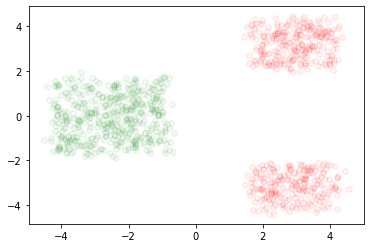

In [7]:
#trying other shapes

square = np.zeros([20,20])
square[6:14,:8] = 1

two_square = np.zeros([20,20])
two_square[:5,14:] = 1
two_square[15:,14:] = 1


annulus = import_img('annulus.png')
circle = 255-import_img('circle.jpeg')

dset = ImageDataset(img=square)
dset1 = ImageDataset(img=two_square)

n = 500
dat = dset.sample(n)
dat1 = dset1.sample(n)
plt.scatter(dat.detach().numpy()[:,0],dat.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='red')
plt.show() 

In [8]:
# make half moon dataset
import sklearn.datasets

moons, labels = sklearn.datasets.make_moons(n,noise=.1) #generates two half moons
mask = (labels == 0)
one_moon = moons[mask,:] # only keep one moon

def rot_mat(theta0):
    #computes rotation matrix of angle theta
    return np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])

theta0 = np.pi/2
theta1 = np.pi

rot0 = rot_mat(theta0)
rot1 = rot_mat(theta1)

# apply rotation to the moon
one_moon_rot0 = np.dot(one_moon,rot0)
one_moon_rot1 = np.dot(one_moon,rot1)

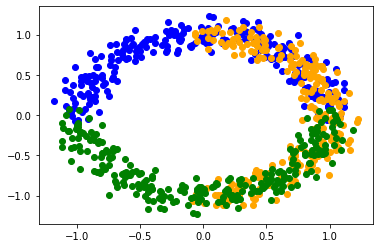

In [9]:
#visualize rotated moons

plt.scatter(one_moon[:,0],one_moon[:,1], color='blue')
plt.scatter(one_moon_rot0[:,0],one_moon_rot0[:,1], color='orange')
plt.scatter(one_moon_rot1[:,0],one_moon_rot1[:,1], color='green')

In [ ]:
# with three timesteps

dat = torch.tensor(one_moon,dtype=torch.float)
dat0 = torch.tensor(one_moon_rot0,dtype=torch.float)
dat1 = torch.tensor(one_moon_rot1,dtype=torch.float)

dat_tuple = (dat,dat0,dat1)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
# with two timesteps


dat_tuple = (dat,dat0)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)
